<h3>Imports<h3/>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import env
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats

from math import sqrt

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

directory = os.getcwd()

# imports for modeling:
# import Logistic regression
from sklearn.linear_model import LogisticRegression
# import K Nearest neighbors:
from sklearn.neighbors import KNeighborsClassifier
# import Decision Trees:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# import Random Forest:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

# interpreting our models:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#feature selection
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

<h1>Exploring Zillow for Regression Project<h1/>

<h3>Acquisition and Prep<h3/>

> <h4>Let's look at the zillow database for properties that had a transaction in 2017, looking at square feet of the home, number of bedrooms, 
and number of bathrooms to estimate the property's assessed value.<h4/>

In [2]:
SQL_query = '''
SELECT bedroomcnt AS bedrooms, 
        bathroomcnt AS bathrooms,
        calculatedfinishedsquarefeet AS total_sqft,
        taxvaluedollarcnt AS home_value    
FROM properties_2017 as pro
JOIN predictions_2017 as pre
	ON pre.id = pro.id
JOIN propertylandusetype as pl
	ON pro.propertylandusetypeid = pl.propertylandusetypeid
WHERE pro.propertylandusetypeid = '261'
'''

In [3]:
from wrangle import get_zillow_data
df = get_zillow_data(SQL_query, directory, filename = 'zillow.csv')

> <h4>What kind of data do I have here?<h4/>

In [4]:
df.info(), df.shape, df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56080 entries, 0 to 56079
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    56080 non-null  float64
 1   bathrooms   56080 non-null  float64
 2   total_sqft  55849 non-null  float64
 3   home_value  56072 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB


(None,
 (56080, 4),
               count           mean            std   min       25%       50%  \
 bedrooms    56080.0       3.289123       0.958752   0.0       3.0       3.0   
 bathrooms   56080.0       2.239470       1.007008   0.0       2.0       2.0   
 total_sqft  55849.0    1868.289119     966.964755  20.0    1260.0    1630.0   
 home_value  56072.0  457637.608967  663553.617856   9.0  187024.0  329522.5   
 
                   75%         max  
 bedrooms         4.00        25.0  
 bathrooms        3.00        20.0  
 total_sqft    2217.00     26345.0  
 home_value  533440.75  67506489.0  )

In [5]:
df.head(2)

,bedrooms,bathrooms,total_sqft,home_value
0,0.0,0.0,NaN,27516.0
1,0.0,0.0,NaN,10.0


> <h4>Do I have any nulls?<h4/>

In [6]:
df.isnull().sum()

bedrooms        0
bathrooms       0
total_sqft    231
home_value      8
dtype: int64

> <b>Quickly looking at the data:

> It appears that there are some nulls, but with 56k rows, I'm just going to remove them and keep it moving.

> The data types are all floats, so I can keep the data types the same.

> I will also run code to replace any blank spaces that might be there<b/>

> > <h4>Let's get rid of the nulls and empty white space<h4/>

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

bedrooms      0
bathrooms     0
total_sqft    0
home_value    0
dtype: int64

In [9]:
df.shape

(55847, 4)

In [10]:
# Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df.
df = df.replace(r'^\s*$', np.nan, regex=True)
df.shape

(55847, 4)

> <h4>The dataset has been reduced by 233 rows, so nothing substantial that will harm the exploration and modeling<h4/>

In [11]:
df.home_value.sort_values(ascending=False).head(50)

3312     30166843.0
10591    22843125.0
24710    19129816.0
13993    18782125.0
35558    17170000.0
35479    14721125.0
7848     14563303.0
13991    13243244.0
46402    12698505.0
25571    12228491.0
20251    11962714.0
24804    11904874.0
32114    11689668.0
29297    11517922.0
21478    11378863.0
13992    10904781.0
30954    10358901.0
9809     10000000.0
44576     9841049.0
3317      9496841.0
40133     9486573.0
3277      9319811.0
32210     9195547.0
43133     9170245.0
848       9094608.0
7847      9075973.0
29299     8941366.0
24705     8802043.0
21150     8724778.0
53458     8634810.0
30953     8585373.0
35449     8450000.0
53487     8232600.0
41852     8037650.0
14033     8000000.0
31927     7961794.0
46328     7878034.0
42088     7766510.0
25258     7766509.0
24666     7621533.0
31932     7463509.0
32024     7424446.0
21315     7307000.0
40143     7215061.0
31807     7196966.0
24686     7189347.0
24790     7116902.0
31911     7029394.0
50879     7000944.0
40137     6953000.0


In [12]:
df = df[df.home_value < 1000000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51858 entries, 4 to 56079
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    51858 non-null  float64
 1   bathrooms   51858 non-null  float64
 2   total_sqft  51858 non-null  float64
 3   home_value  51858 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


In [13]:
df.describe()

,bedrooms,bathrooms,total_sqft,home_value
count,51858.000000,51858.000000,51858.000000,51858.000000
mean,3.244051,2.119355,1726.930483,346557.526939
std,0.891833,0.809394,688.578706,219501.951833
min,0.000000,0.000000,20.000000,9.000000
25%,3.000000,2.000000,1239.000000,176856.000000
50%,3.000000,2.000000,1578.000000,307521.000000
75%,4.000000,2.500000,2079.000000,476000.000000
max,11.000000,9.000000,9200.000000,999948.000000


> <h4>The dataset has been cleaned of extremely high home values (outliers), so nothing substantial that will harm the exploration and modeling<h4/>

<h3>Exploration<h3/>

> <b>Time to look at the Distributions<b/>

> > <b>Univariate Distributions<b/>

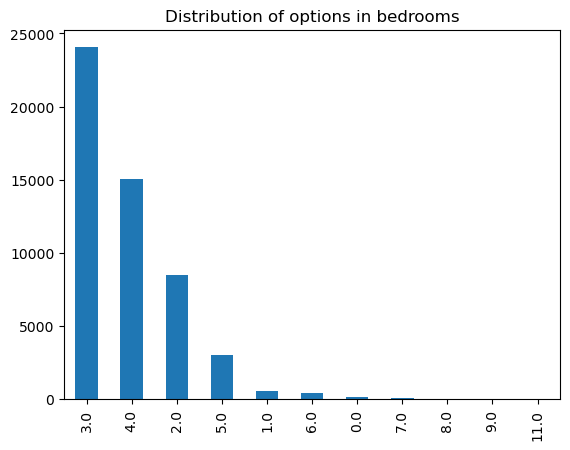

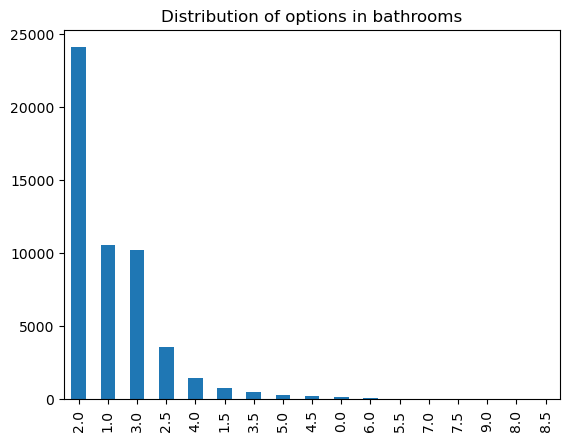

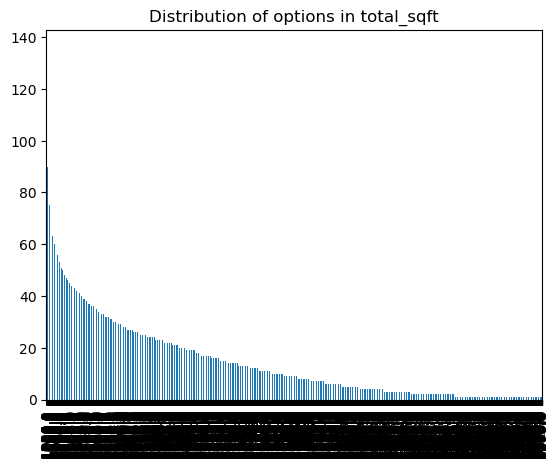

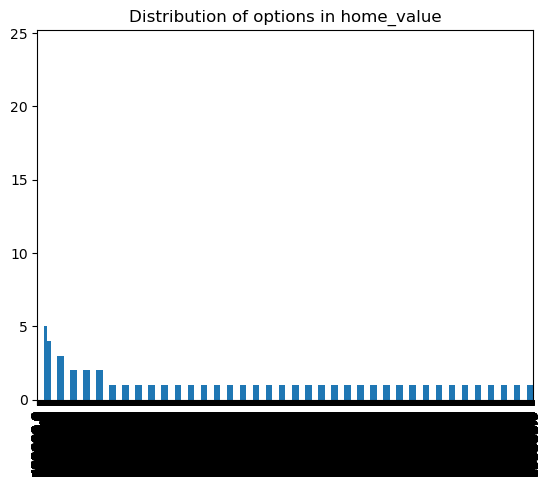

In [14]:
for col in df:
    df[col].value_counts().plot(
        kind='bar').set(
        title=f'Distribution of options in {col}')
    plt.show()

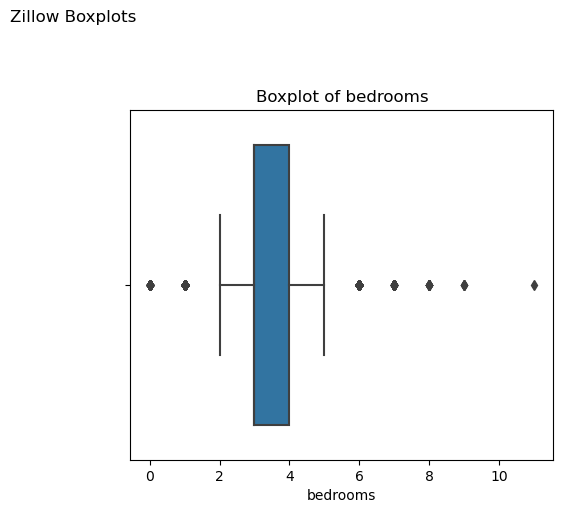

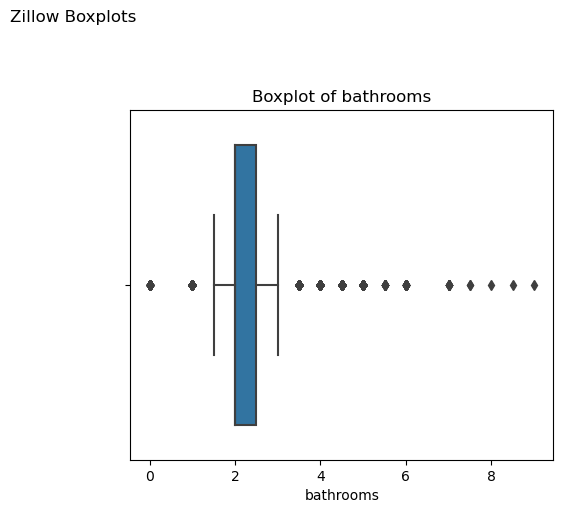

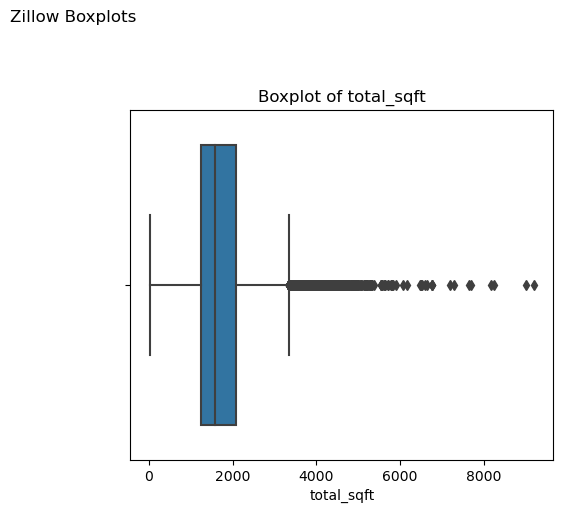

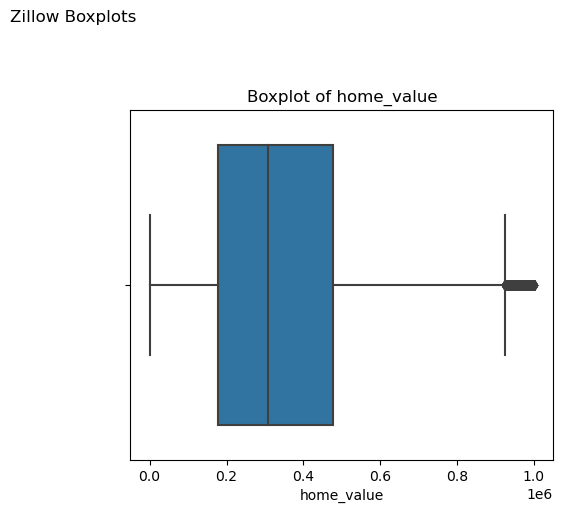

In [15]:
for col in df:
    plt.figure(figsize=(12, 10))
    plt.suptitle('Zillow Boxplots')

    plt.subplot(222)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')

> <b>Univariate Exploring Takeaways\
    - The distribution for all features presents with a right skew, which means that the mean is to the right of the median\
    - Overall, nothing special here, but the distribution type will be important for future statistic testing<b/>

> <b>Time to split the data before exploring bi- and multi-variate relationships to avoid leakage of unseen data<b/>

In [16]:
# Splitting . . .
from wrangle import split_zillow_data
train, validate, test = split_zillow_data(df)
train.shape, validate.shape, test.shape

((29040, 4), (12446, 4), (10372, 4))

In [17]:
train.head()

,bedrooms,bathrooms,total_sqft,home_value
43919,3.0,2.0,1299.0,219345.0
47982,4.0,2.0,1557.0,230853.0
14545,2.0,1.0,768.0,444346.0
19326,4.0,2.0,1262.0,53624.0
8118,4.0,2.0,2410.0,424168.0


In [18]:
#Let's split up the train data between X and y
X_train = train.drop(columns={'home_value'})
y_train = train['home_value']
X_validate = validate.drop(columns={'home_value'})
y_validate = validate['home_value']
X_test = test.drop(columns={'home_value'})
y_test = test['home_value']

> > <b>Correlation Matrix<b/>

In [19]:
# Create the correlation matrix for all columns.
train_corr = train.corr()
train_corr

,bedrooms,bathrooms,total_sqft,home_value
bedrooms,1.000000,0.625463,0.619226,0.256650
bathrooms,0.625463,1.000000,0.795004,0.421997
total_sqft,0.619226,0.795004,1.000000,0.494991
home_value,0.256650,0.421997,0.494991,1.000000


> > > > <b>Heatmap<b/>

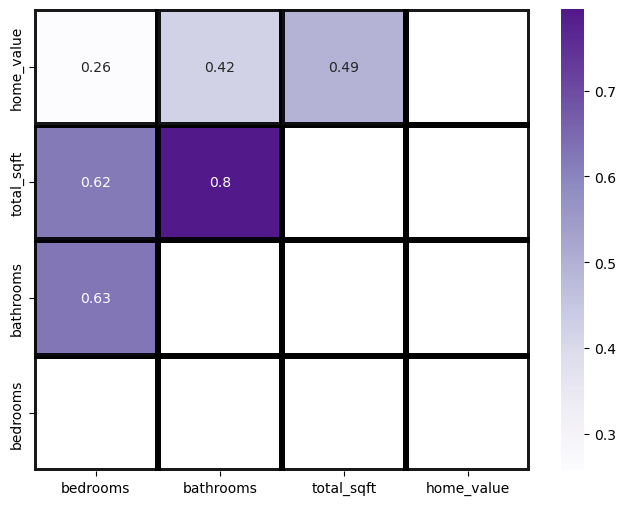

In [20]:
# Pass my correlation matrix to Seaborn's heatmap.
kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='Purples', annot=True, mask= np.triu(train_corr), **kwargs)
plt.ylim(0, 4)

plt.show()

> <b>Heatmap takeaways:<b/>\
    - I'm seeing the strongest correlation between home value and total square feet, who would've thought\
    - The next strongest correlations was bathrooms, with bedrooms having a very weak correlation 

> > <b>Scatterplot Viz<b/>

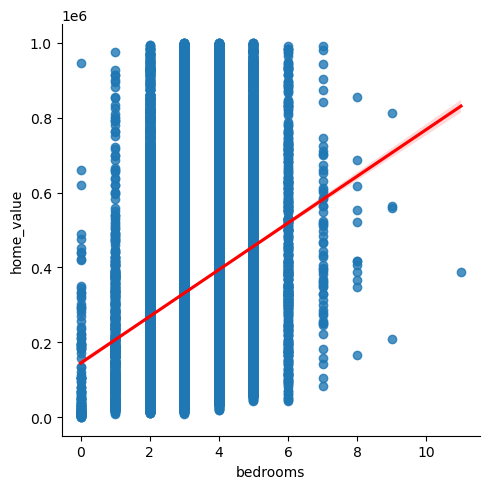

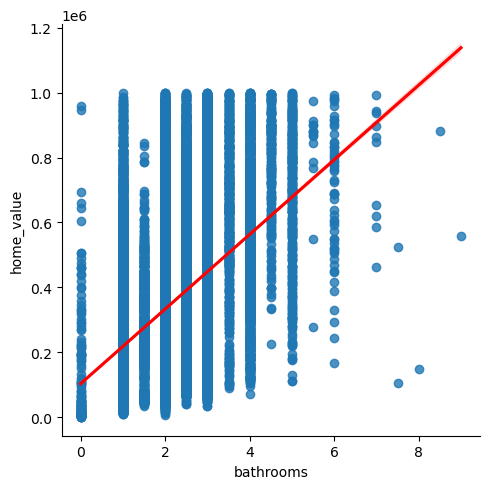

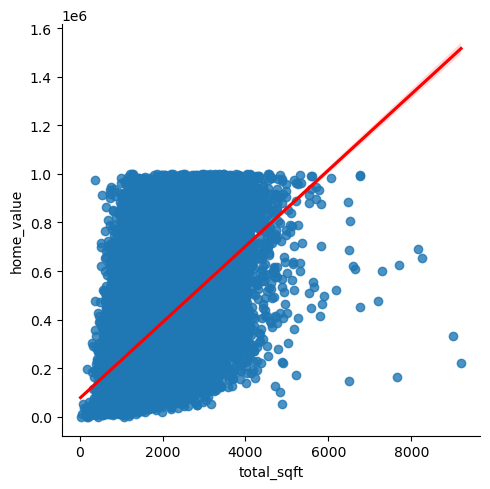

In [21]:
# Scatterplot with a regression line
sns.lmplot(x="bedrooms", y="home_value", data=df, line_kws={'color': 'red'})
plt.show()
sns.lmplot(x="bathrooms", y="home_value", data=df, line_kws={'color': 'red'})
plt.show()
sns.lmplot(x="total_sqft", y="home_value", data=df, line_kws={'color': 'red'})
plt.show()

> <b>Scatterplot takeaways:<b/>\
    - There seems to be some correlation between home value and all of the features as evidenced by the regression line.

> > <b>Pairplot Viz<b/>

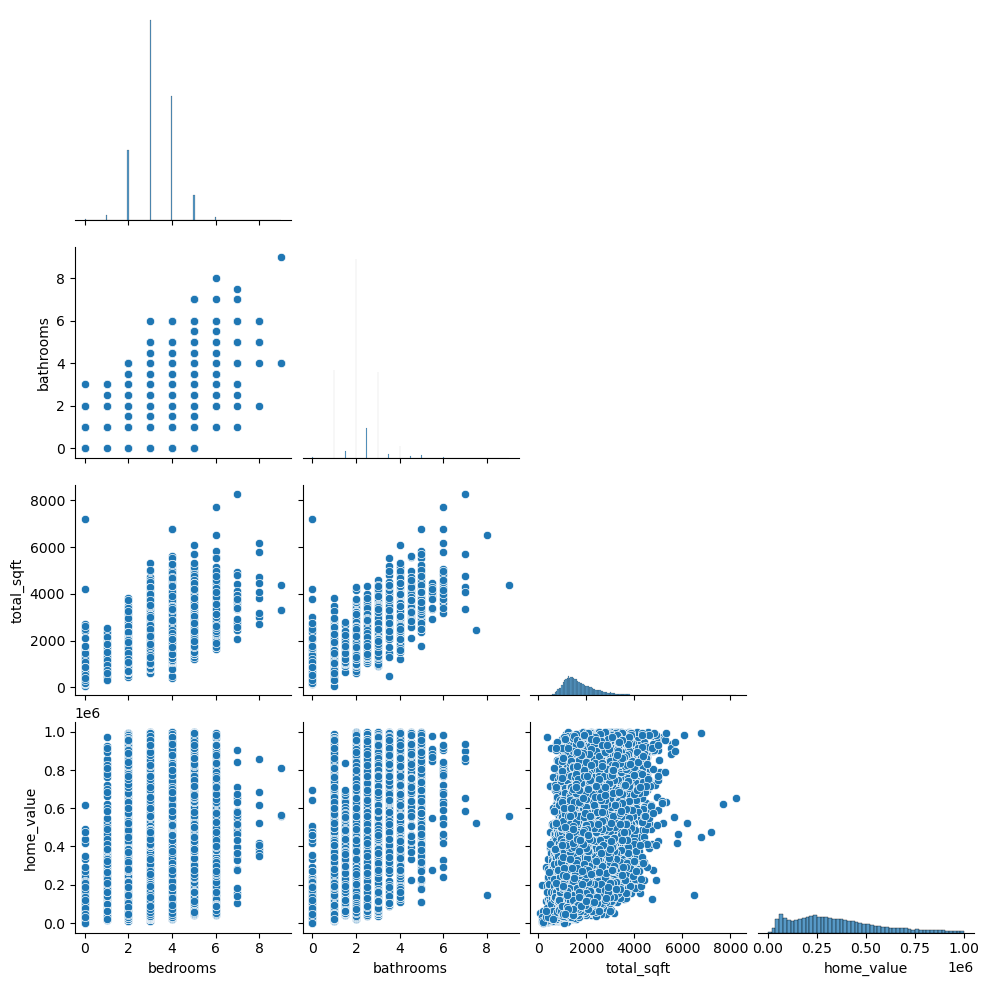

In [22]:
sns.pairplot(train[['bedrooms', 'bathrooms', 'total_sqft', 'home_value']], corner=True)
plt.show()

> Pairplot Takeaways:\
    -\
    -

> > <b>Boxplot Viz<b/>

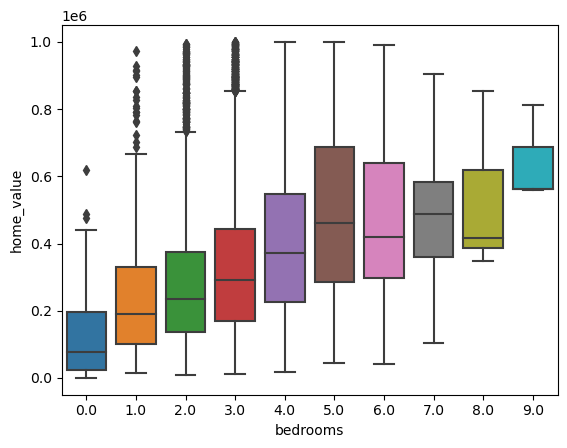

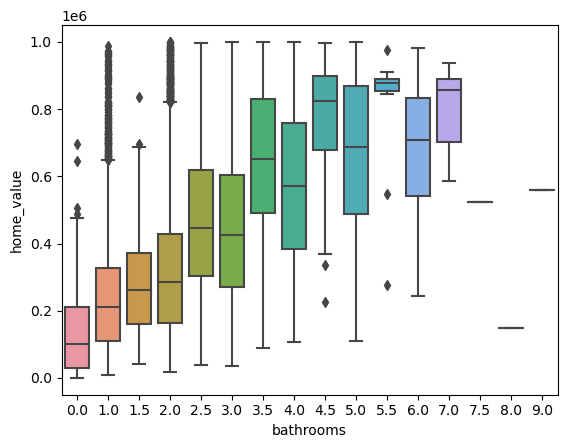

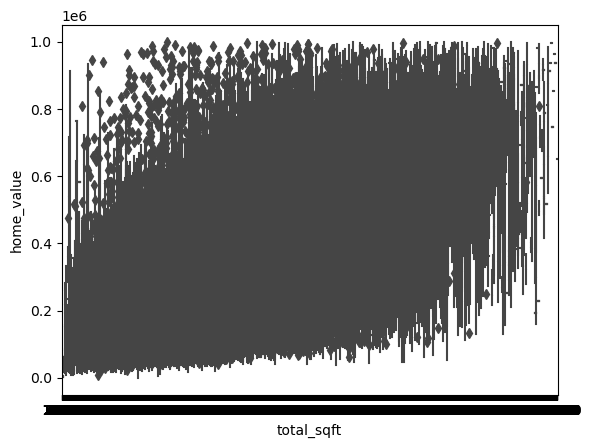

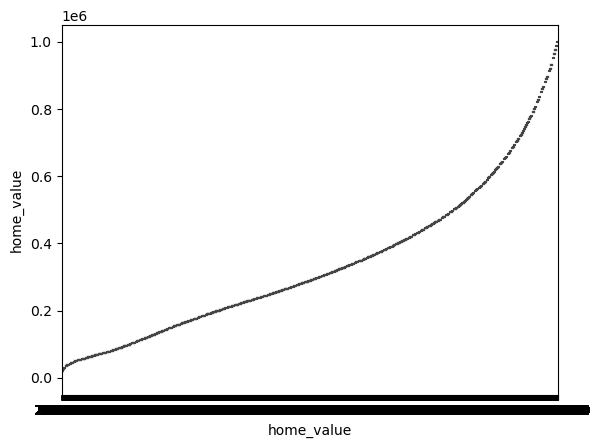

In [23]:
for col in train:
    sns.boxplot(data = train, y = train.home_value, x = col)
    plt.show()

> <b>Boxplot Takeaways<b/>\
    - It appears the more bedrooms you have, the higher the home value, especially if you have eight bedrooms\
    - 

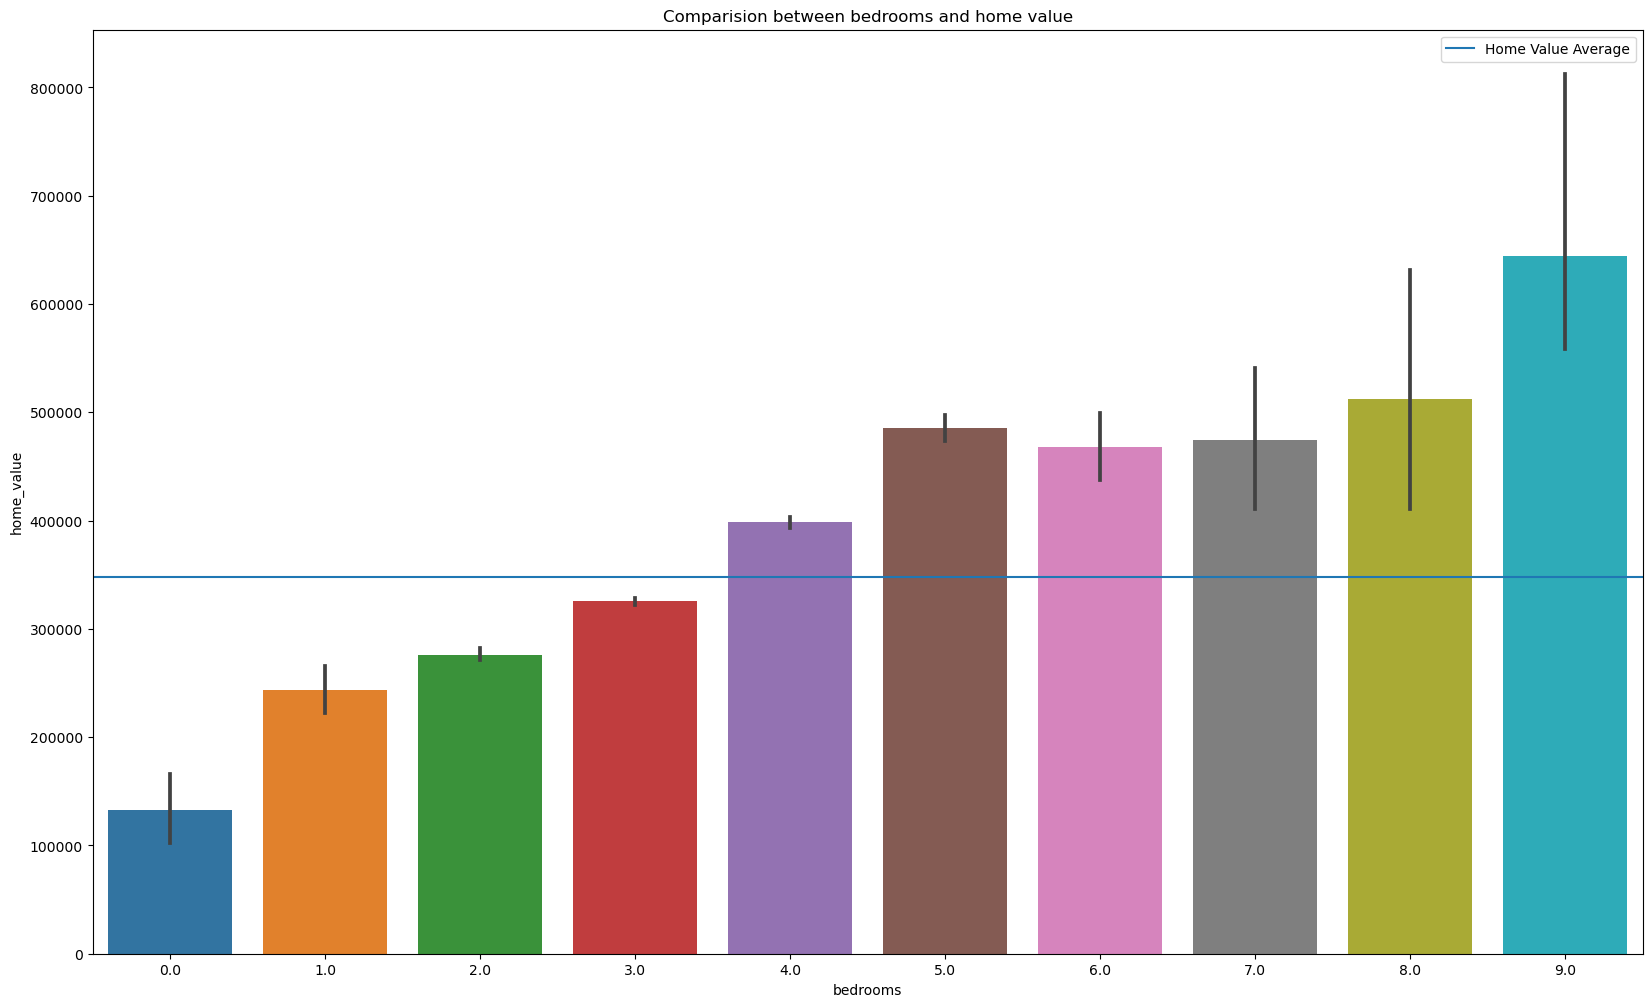

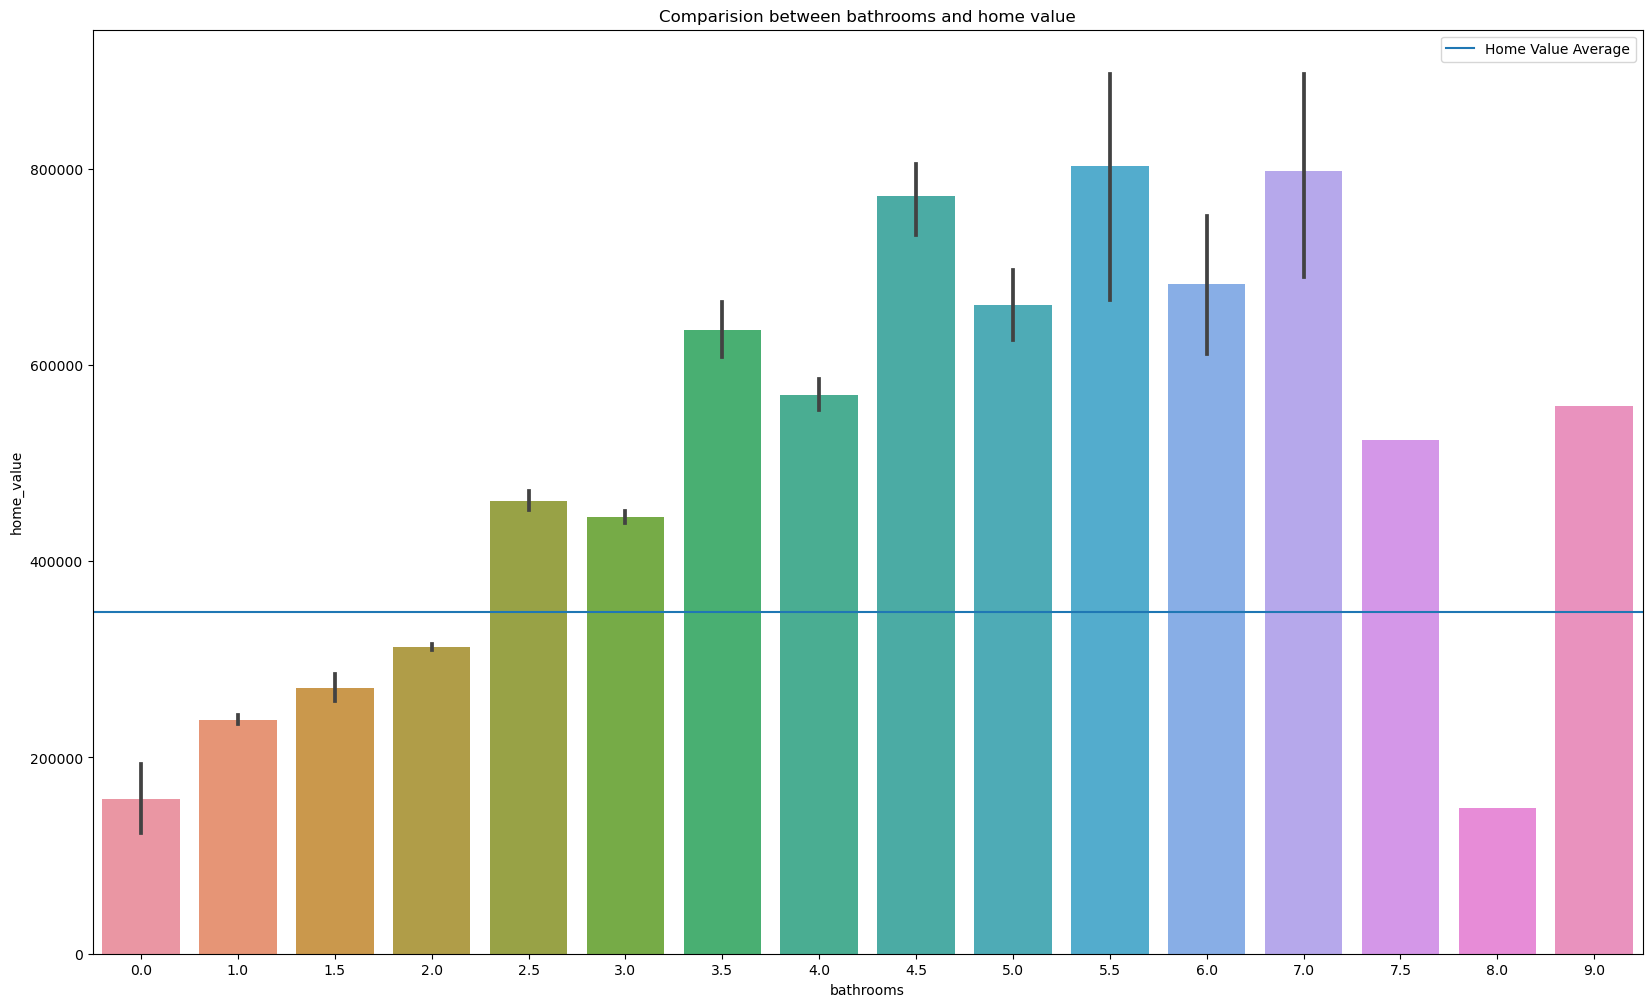

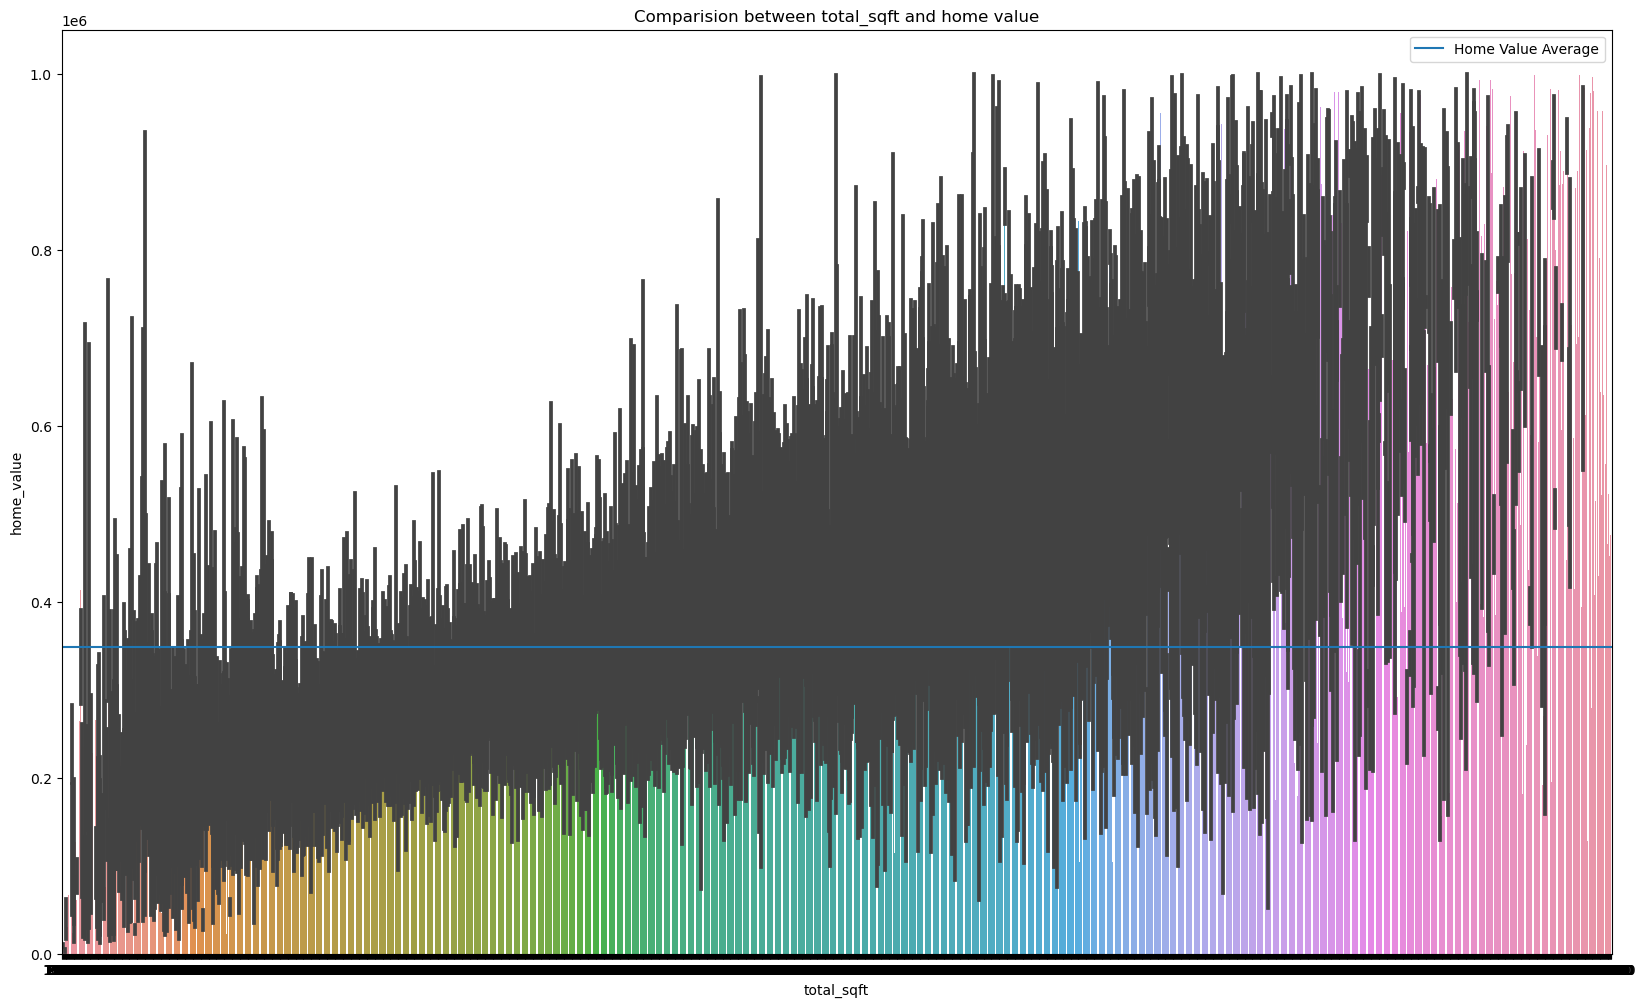

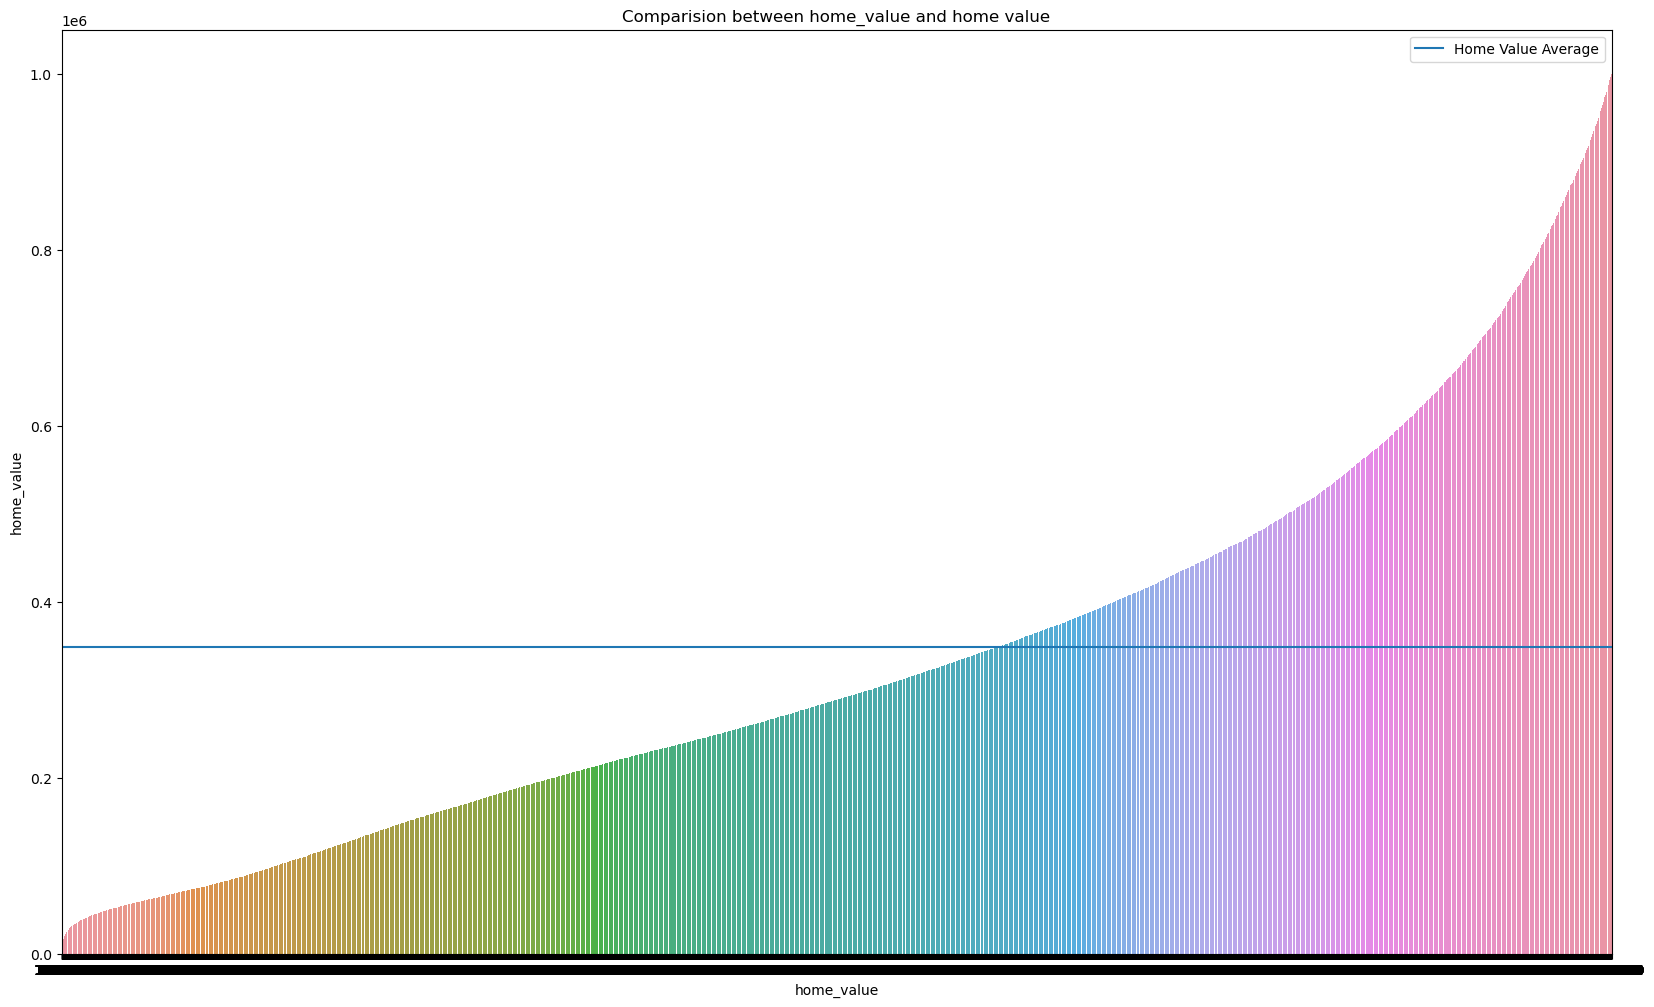

In [24]:
for col in train:
    plt.figure(figsize=(20,12))
    plt.title(f"Comparision between {col} and home value")
    sns.barplot(x=col, y="home_value", data=train)
    home_value_average = train.home_value.mean()
    plt.axhline(home_value_average, label="Home Value Average")
    plt.legend()
    plt.show()

<Axes: xlabel='home_value', ylabel='total_sqft'>

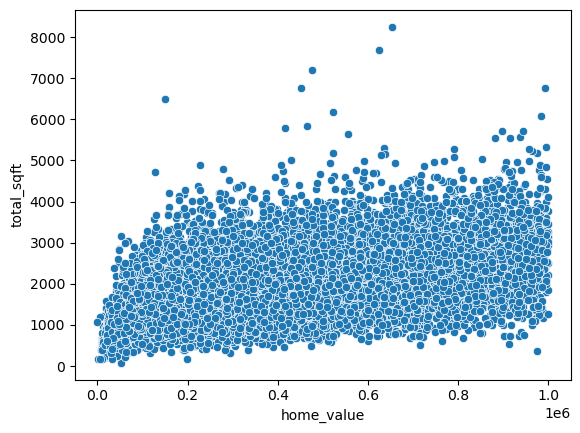

In [25]:
x='home_value'
y = 'total_sqft'
sns.scatterplot(data=train, x='home_value', y = 'total_sqft', sizes=.001)


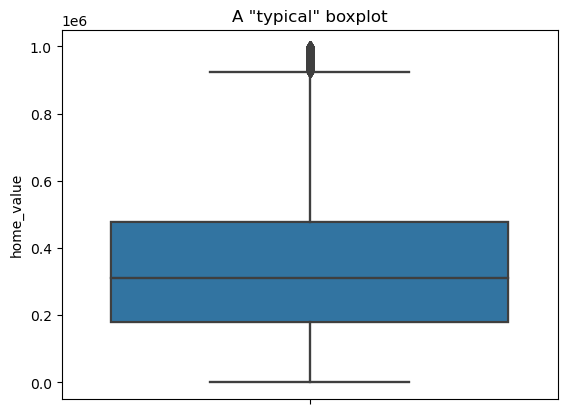

In [26]:
for col in train:
    sns.boxplot(data=train, y='home_value')
    plt.title('A "typical" boxplot')

<h3>Scaling Numeric Data<h3/>

In [27]:
from wrangle import scale_data
train, validate, test = scale_data(train, validate, test)
train.head()

,home_value,Bedroom_Count_Scaled,Bathroom_Count_Scaled,Finished_sqft_Scaled
43919,219345.0,0.333333,0.222222,0.149394
47982,230853.0,0.444444,0.222222,0.180962
14545,444346.0,0.222222,0.111111,0.084424
19326,53624.0,0.444444,0.222222,0.144867
8118,424168.0,0.444444,0.222222,0.285330


In [28]:
#Let's split up the train data between X and y
X_train_scaled = train.drop(columns={'home_value'})
y_train_scaled = train['home_value']
X_validate_scaled = validate.drop(columns={'home_value'})
y_validate_scaled = validate['home_value']
X_test_scaled = test.drop(columns={'home_value'})
y_test_scaled = test['home_value']

<h3>Feature Engineering<h3/>

> <b>Select K Best

In [29]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me the top feature
f_selector = SelectKBest(f_regression, k=1)

# find the top X correlated with y
f_selector.fit(X_train_scaled, y_train)

# save top features
f_features = f_selector.get_feature_names_out()
f_features

array(['Finished_sqft_Scaled'], dtype=object)

> <b>Recursive Feature Elimination

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get list of the column names. 
rfe_feature = rfe.get_feature_names_out()
rfe_feature

array(['Bathroom_Count_Scaled', 'Finished_sqft_Scaled'], dtype=object)

In [31]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Variable': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank').head()

,Variable,Rank
1,Bathroom_Count_Scaled,1
2,Finished_sqft_Scaled,1
0,Bedroom_Count_Scaled,2



<h3>Evaluating Regression Models<h3/>

In [32]:
# X -> set of all ind features
#y -> dependent variable, target
X = X_train_scaled
y = y_train_scaled

In [33]:
#Time to make, fit, & use the regression model using Ordinary Least Squares Linear Regression (OLS) method
from sklearn.linear_model import LinearRegression

#make
lm = LinearRegression()
#fit
lm.fit(X,y)
#use
yhat = lm.predict(X)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
baseline_med = y.median()
baseline_mean = y.mean()

In [36]:
y_pred = pd.DataFrame(
    {
    'y_act': y.values,
    'yhat' : yhat,
    'baseline_med': baseline_med,
    'baseline_mean': baseline_mean
    }, index=train.index)

In [37]:
# compute the error on these two baselines:
mean_baseline_rmse = mean_squared_error(y_pred.baseline_mean, y) ** (1/2)
med_baseline_rmse = mean_squared_error(y_pred.baseline_med, y) ** (1/2)

In [38]:
mean_baseline_rmse < med_baseline_rmse

True

In [39]:
#  mean providees our best baseline,
print(f'Root mean squared error for the mean value of home price is ${round(mean_baseline_rmse, 3)}.')

Root mean squared error for the mean value of home price is $219813.861.


In [40]:
#Establish the true baseline
baseline = mean_baseline_rmse
baseline

219813.86084096498

> > <b>Plot the residuals for the linear regression model that you made.<b/>

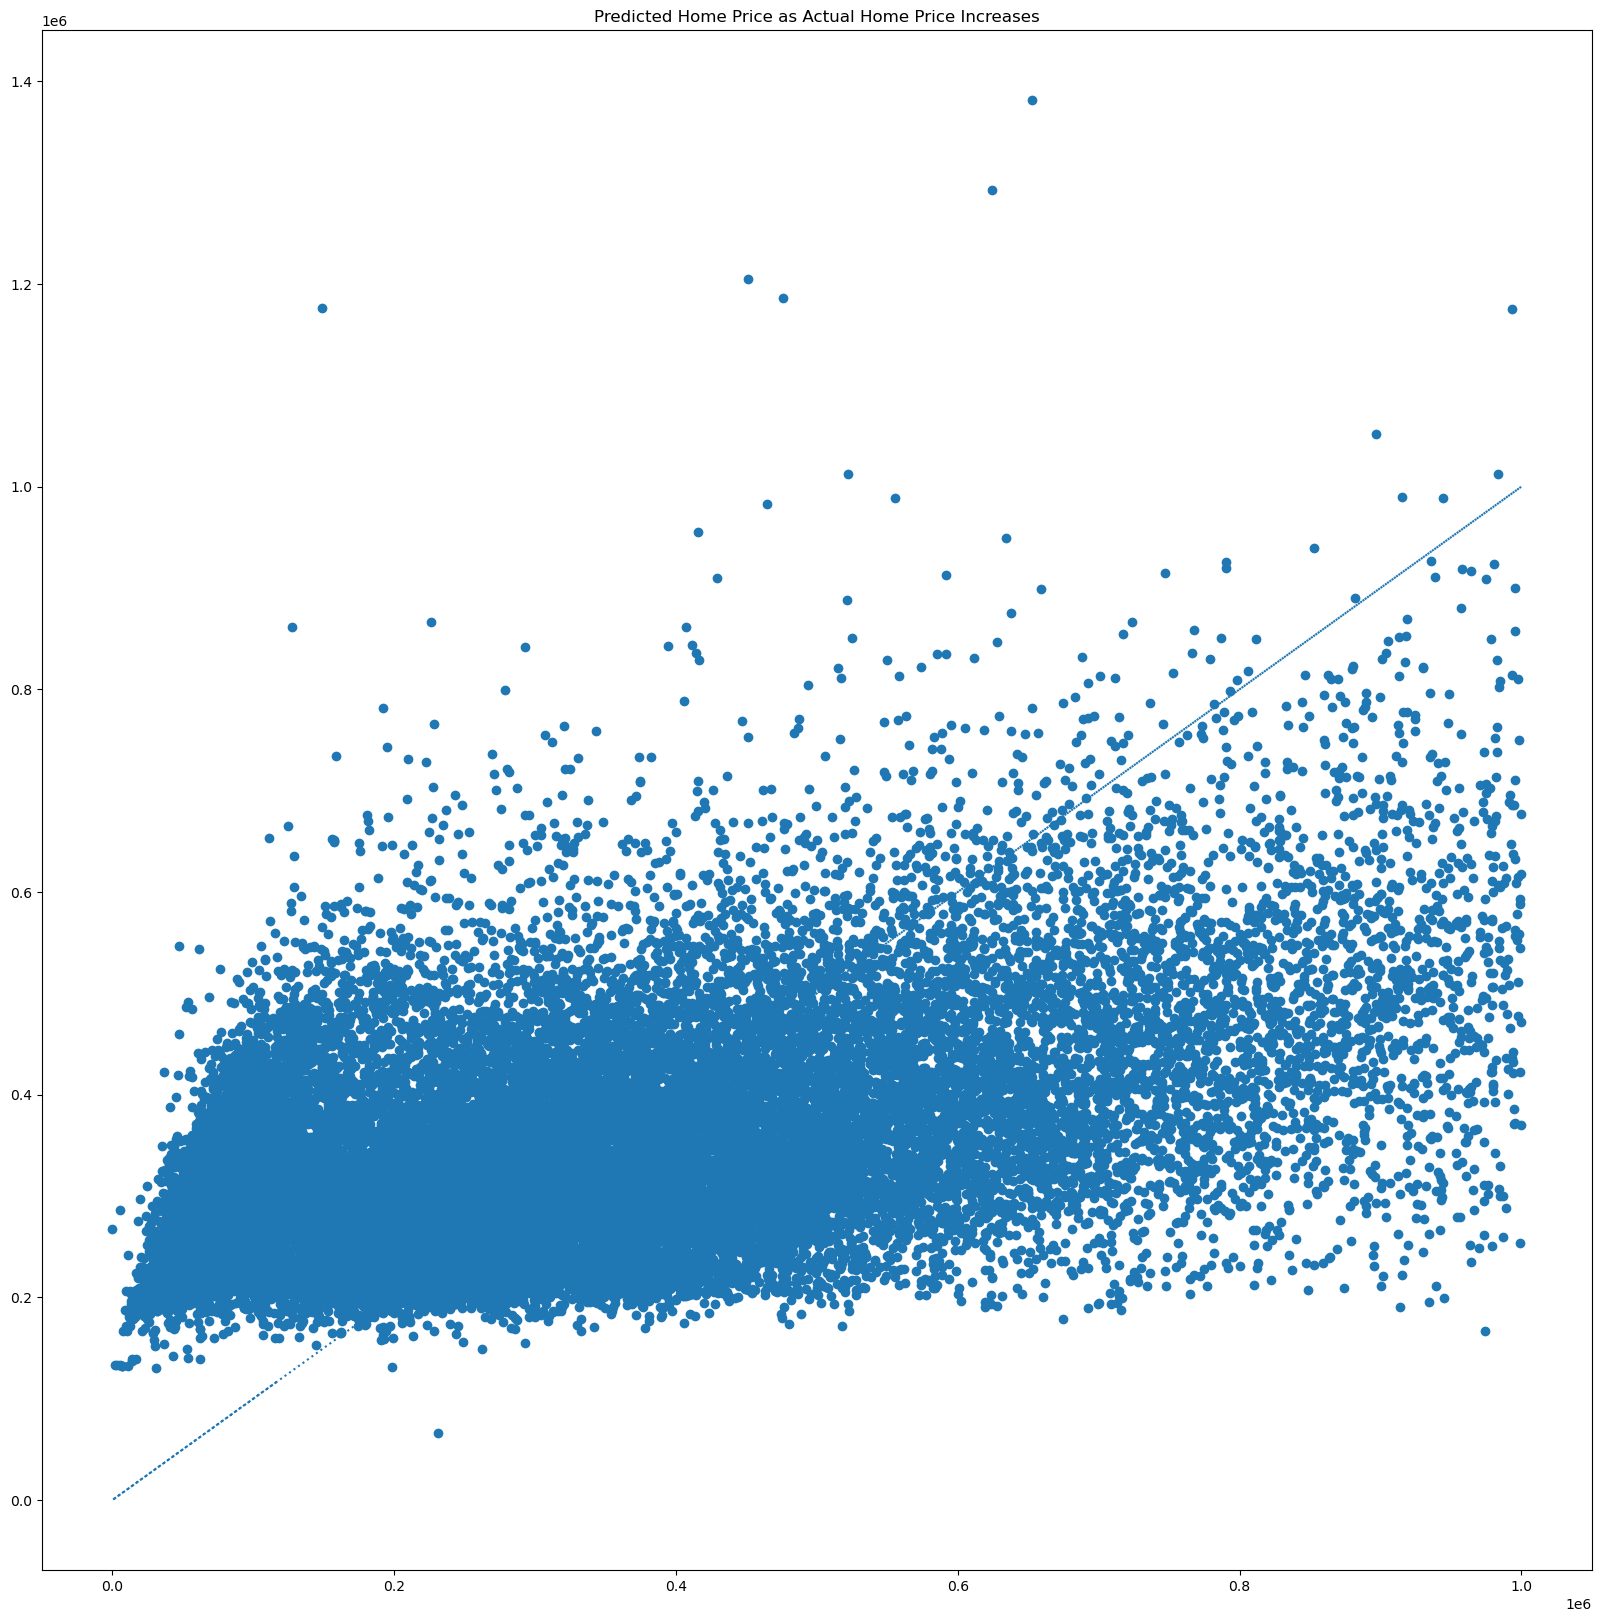

In [41]:
# plot residuals the first way
plt.figure(figsize=(20,20))
plt.scatter(y, yhat)
# x=x is y=y here, the cases where the vert axis matches the horiz axis
plt.plot(y,y, ls=':')
plt.title('Predicted Home Price as Actual Home Price Increases')
plt.show()

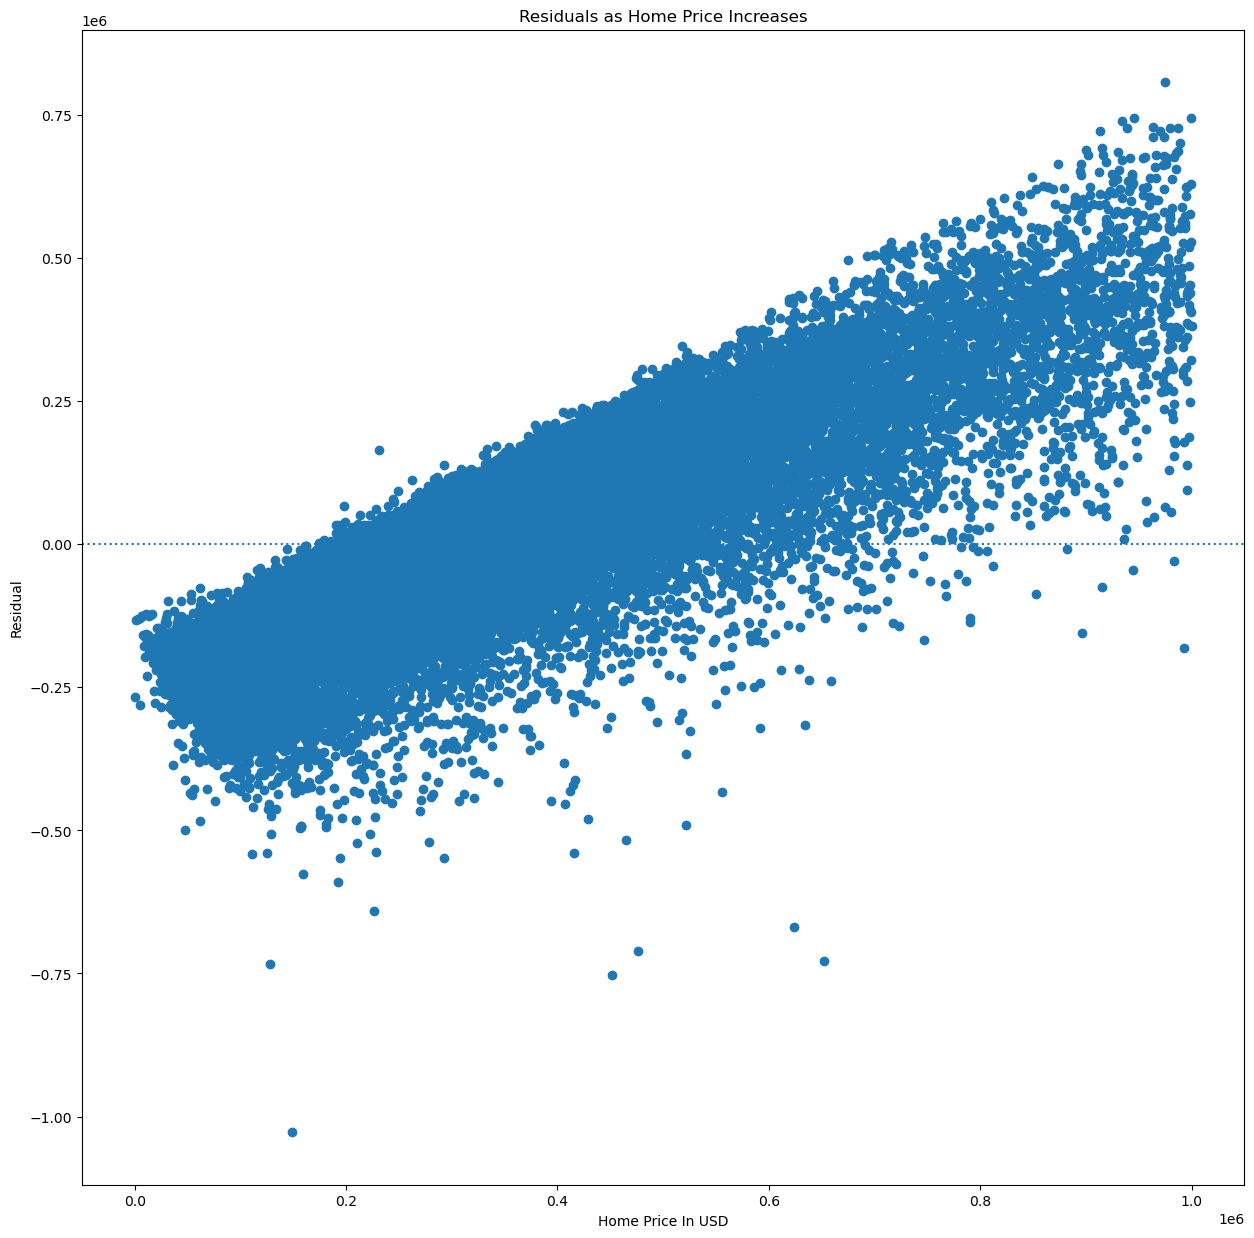

In [42]:
# plot them the other way
plt.figure(figsize=(15,15))
plt.scatter(y, (y-yhat))
plt.axhline(0,ls=':')
plt.title('Residuals as Home Price Increases')
plt.xlabel('Home Price In USD')
plt.ylabel('Residual')
plt.show()

> > <b>Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model.<b/>

In [43]:
# Squared Errors, 
# residuals squared
squared_errors = (y_pred['y_act'] - y_pred['yhat']) ** 2
# Sum of Squared Error, 
sse = squared_errors.sum()
# Mean Squared error, 
mse = sse / train.shape[0] #alternatively, len(train), y_pred.shape[0]
# Root mean Squared Error
# square root the mean squared error!
rmse = mse**0.5

In [44]:
# Squared Errors, 
# residuals squared
squared_errors_bl = (y_pred['y_act'] - y_pred['baseline_mean']) ** 2
# Sum of Squared Error, 
sse_bl = squared_errors_bl.sum()

sse, sse_bl

(1047332964478446.5, 1403158594453235.0)

> > <b>Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [45]:
sse_bl > sse

True

> > <b>What is the amount of variance explained in your model?

In [46]:
# ESS = Δ(y_pred, y_mean)
ESS = ((y_pred['yhat'] - y_pred['baseline_mean']) ** 2).sum()

> > <b>Is your model better than the baseline model?
<b/>

In [47]:
mean_baseline_rmse > mean_squared_error(y, y_pred['yhat'], squared=False)

True

In [48]:
mean_baseline_rmse

219813.86084096498

In [49]:
mean_squared_error(y, y_pred['yhat'], squared=False)

189908.35876079608

<h3>Modeling<h3/>

In [50]:
#Establish the true baseline
baseline_rmse = mean_baseline_rmse

In [51]:
from wrangle import evaluate_reg
evaluate_reg(y, yhat)

(189908.35876079608, 0.2535890321887969)

In [52]:
y.shape

(29040,)

In [53]:
# make sure that we have a baseline guess
# that is the same shape as our y variable:
# np.repeat does what it sounds like
baseline_array = np.repeat(baseline_rmse, y.shape[0])

In [54]:
baseline_rsme, baseline_r2 = evaluate_reg(y, baseline_array)

> > <b>Create a dataframe to compare the models<b/>

In [55]:
eval_df = pd.DataFrame([{
    'model': 'baseline',
    'rmse': baseline_rmse,
    'r2': baseline_r2
}])

In [56]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371


> <b>------------------------------Ordinary Least Squares (OLS)------------------------------

In [57]:
#IMPORT
from sklearn.feature_selection import RFE

In [58]:
# first ML model
lr1 = LinearRegression()

# create the thing
rfe = RFE(lr1, n_features_to_select = 2)

# fit the thing
rfe.fit(X, y)

# use it/transform your X_train & validate data splits
X_train_rfe = rfe.transform(X)

X_val_rfe = rfe.transform(validate.drop(columns = ['home_value']))

In [59]:
X_train_rfe

array([[0.22222222, 0.14939435],
       [0.22222222, 0.1809617 ],
       [0.11111111, 0.08442432],
       ...,
       [0.11111111, 0.0658265 ],
       [0.22222222, 0.25988009],
       [0.33333333, 0.23173865]])

In [60]:
# What features got selected for predicting Tax_value dollars (also known as Home Value)??
rfe.get_feature_names_out()

array(['Bathroom_Count_Scaled', 'Finished_sqft_Scaled'], dtype=object)

In [61]:
#Creating a X and y for validate and test

X_val, y_val = validate.drop(columns=['home_value']), validate['home_value']
X_test, y_test = test.drop(columns=['home_value']), test['home_value']

In [62]:
lr1

LinearRegression()

In [63]:
lr1.fit(X_train_rfe, y)

LinearRegression()

In [64]:
y_pred_val = lr1.predict(X_val_rfe)

In [65]:
evaluate_reg(y, lr1.predict(X_train_rfe))

(190716.9173896254, 0.24721962530958752)

In [66]:
rmse, r_2 = evaluate_reg(y, lr1.predict(X_train_rfe))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'ordinary_least_squares',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [67]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371
1,ordinary_least_squares,190716.917390,0.247220


In [68]:
lr1.coef_

array([ 188969.02614347, 1134101.57769963])

In [69]:
lr1.intercept_

74189.60543692944

In [70]:
#For Variable 1:
print(f'For every 1 point increase in "Bedroom Count", we predict a {lr1.coef_[0]:.2f} point increase or decrease in Home Value')
#For Variable 2:
print(f'For every 1 point increase in "Bathroom Count", we predict a {lr1.coef_[1]:.2f} point increase or decrease in Home Value')

For every 1 point increase in "Bedroom Count", we predict a 188969.03 point increase or decrease in Home Value
For every 1 point increase in "Bathroom Count", we predict a 1134101.58 point increase or decrease in Home Value


In [71]:
val_rmse, val_r2 = evaluate_reg(y_val, lr1.predict(X_val_rfe))
val_dict = {
    'model': 'ols_rfe_1',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [72]:
val_scores = [val_dict]
val_scores

[{'model': 'ols_rfe_1',
  'val_rmse': 189180.62567043433,
  'val_r2': 0.23878504776253295}]

> <b>------------------------------Multiple Regression------------------------------<b/>

In [73]:
# same process here, we are just changing the number of features that we are using in selecting our outcome in OLS

lr2 = LinearRegression()

# fit it:
lr2.fit(X, y)

# use it:

LinearRegression()

In [74]:
rmse, r_2 = evaluate_reg(y, lr2.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'Multiple Regression - All Features',
        'rmse': rmse,
        'r2': r_2
        
    }
])], ignore_index=True, axis=0)

In [75]:
val_rmse, val_r2 = evaluate_reg(y_val, lr2.predict(X_val))
val_dict = {
    'model': 'Multiple Regression - All Features',
    'rmse': val_rmse,
    'r2': val_r2
}
val_scores.append(val_dict)

In [76]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371
1,ordinary_least_squares,190716.917390,0.247220
2,Multiple Regression - All Features,189908.358761,0.253589


> <b>------------------------------LassoLars------------------------------
<b/>

In [77]:
from sklearn.linear_model import LassoLars

In [78]:
#Make the thing
lasso = LassoLars(alpha=1)

#Fit the thing
lasso = lasso.fit(X, y)

In [79]:
lasso.coef_

array([-234290.31006816,  282341.57325342, 1225692.79081237])

In [80]:
lr2.coef_

array([-234610.46702029,  282518.90340962, 1225917.44749889])

In [81]:
rmse, r_2 = evaluate_reg(y, lasso.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'LassoLars',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index=True, axis=0)

In [82]:
val_rmse, val_r2 = evaluate_reg(y_val, lasso.predict(X_val))
val_dict = {
    'model': 'LassoLars',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [83]:
val_scores.append(val_dict)

In [84]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371
1,ordinary_least_squares,190716.917390,0.247220
2,Multiple Regression - All Features,189908.358761,0.253589
3,LassoLars,189908.360662,0.253589


> <b>------------------------------Polynomial Regression------------------------------<b/>

In [85]:
from sklearn.preprocessing import PolynomialFeatures

In [86]:
#Make the thing
pf = PolynomialFeatures(degree=2)

#fit the thing and USE it on train
x_train_sq = pf.fit_transform(X)

#Use the thing on Val and Test
x_val_sq = pf.transform(X_val)
x_test_sq = pf.transform(X_test)

In [87]:
# Make a new model for our polynomial regressor:

plyreg = LinearRegression()
plyreg.fit(x_train_sq, y)

LinearRegression()

In [88]:
#Evaluate

rmse, r_2 = evaluate_reg(y, plyreg.predict(x_train_sq))
eval_df = pd.concat([eval_df, pd.DataFrame(
[{
    'model': 'Polynomial Regression',
    'rmse': rmse,
    'r2': r_2
}

]
)], ignore_index=True, axis=0 )

In [89]:
val_rmse, val_r2 = evaluate_reg(y_val, plyreg.predict(x_val_sq))
val_dict = {
    'model': 'Polynomial Regression',
    'rmse': val_rmse,
    'r2': val_r2
}

In [90]:
val_scores.append(val_dict)

In [91]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371
1,ordinary_least_squares,190716.917390,0.247220
2,Multiple Regression - All Features,189908.358761,0.253589
3,LassoLars,189908.360662,0.253589
4,Polynomial Regression,189457.335386,0.257130


<h3>------------------------------Generalized Linear Model (GLM)------------------------------
<h3/>

In [92]:
from sklearn.linear_model import TweedieRegressor

In [93]:
# Make the thing
gams = TweedieRegressor(power = 0)
# Fit the thing
gams.fit(X, y)

TweedieRegressor(power=0)

In [94]:
#Use the thing
rmse, r_2 = evaluate_reg(y, gams.predict(X))

eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'model': 'Generalized Linear Model',
        'rmse': rmse,
        'r2': r_2
    }
])], ignore_index = True, axis=0)

In [95]:
val_rmse, val_r2 = evaluate_reg(y_val, gams.predict(X_val))

val_dict = {
    'model': 'gamma_GLM',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}

In [96]:
val_scores.append(val_dict)

In [97]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371
1,ordinary_least_squares,190716.917390,0.247220
2,Multiple Regression - All Features,189908.358761,0.253589
3,LassoLars,189908.360662,0.253589
4,Polynomial Regression,189457.335386,0.257130
5,Generalized Linear Model,218995.315731,0.007434


In [98]:
eval_df.loc[eval_df.rmse == eval_df.rmse.min()]

,model,rmse,r2
4,Polynomial Regression,189457.335386,0.25713


<h2>Evaluate the final model on the Test data
<h2/>

In [99]:
# The model I selected was 'Polynomial Regression'


In [100]:
test_rmse, test_r2 = evaluate_reg(y_test, plyreg.predict(x_test_sq))
val_dict = {
    'model': 'Test Polynomial Regression',
    'rmse': test_rmse,
    'r2': test_r2
}

In [101]:
val_scores.append(val_dict)

In [102]:
eval_df

,model,rmse,r2
0,baseline,219813.860841,-0.339371
1,ordinary_least_squares,190716.917390,0.247220
2,Multiple Regression - All Features,189908.358761,0.253589
3,LassoLars,189908.360662,0.253589
4,Polynomial Regression,189457.335386,0.257130
5,Generalized Linear Model,218995.315731,0.007434


In [103]:
val_dict

{'model': 'Test Polynomial Regression',
 'rmse': 191498.66829368088,
 'r2': 0.2542838553661544}

ValueError: Could not interpret input 'bedrooms'

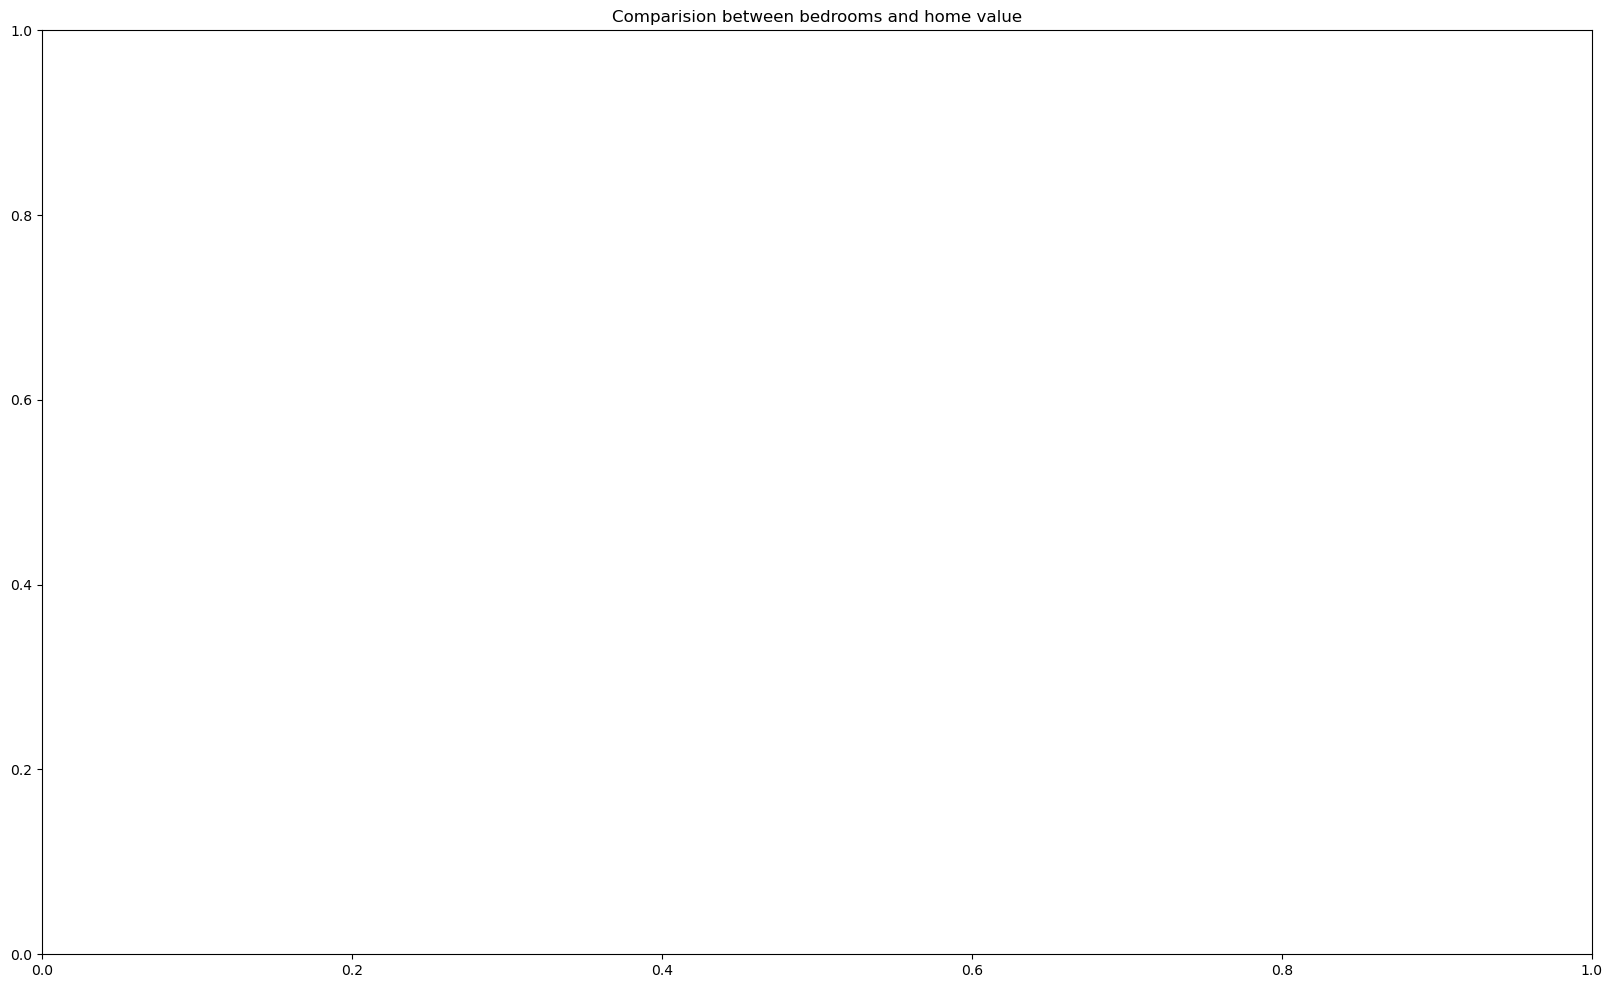

In [106]:
Predicting_Home_Value_via_Bathrooms(train)
    sns.boxplot(data = train, y = train.home_value, x = train.bathrooms)
    plt.show()